### Code used for single cell data analysis and generation of anndata object
_Arginine methyltransferase regulates monocyte extravasation and function._ Thomas M Conlon, Gizem Günes Günsel, et. al and Ali Yildirim

In [1]:
## This Notebook generates the anndata object used in other Notebooks

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
from matplotlib import colors
from natsort import natsorted

folder = "20210925_Yildirim_Prmt7MonocyteExtravasation_meshal.ansari/"

sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({"font.size": 14})

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 3
sc.logging.print_version_and_date()

Running Scanpy 1.8.0, on 2021-09-27 13:20.


### Read in Data Files

In [2]:
## Read in filtered Raw Count Matrix
adata = sc.read(folder + "MonocyteExtravasation_raw_counts.mtx")
adata.obs_names = pd.read_csv(folder + "MonocyteExtravasation_barcodes.txt", header = None).iloc[:, 0].values
adata.var_names = pd.read_csv(folder + "MonocyteExtravasation_genes.txt", header = None).iloc[:, 0].values

## Meta Data
adata.obs = pd.read_csv(folder + "MonocyteExtravasation_cells_metadata.txt", sep = "\t", index_col = 0)
sc._utils.sanitize_anndata(adata)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


... storing 'Sample_ID' as categorical
... storing 'Air' as categorical
... storing 'Condition' as categorical
... storing 'Celltype' as categorical


In [3]:
adata

AnnData object with n_obs × n_vars = 68256 × 27780
    obs: 'Sample_ID', 'Air', 'Condition', 'Louvain_Cluster', 'Celltype', 'pct_mitochondrial', 'size_factors', 'total_counts', 'total_genes'

In [4]:
print(adata.obs_names[:10].values)
print(adata.var_names[:10].values)
adata.X[5:10, :10].todense()

['muc13913_0_GAACGCGCAAAC' 'muc13913_0_TCATCACAAAGA'
 'muc13913_0_GCCCTTCAGAAT' 'muc13913_0_ACACCCCTATTG'
 'muc13913_0_GGGTCCAATTGG' 'muc13913_0_TGCACGACACAC'
 'muc13913_0_GCGCGTAGCTGG' 'muc13913_0_GGTCCGAATGTG'
 'muc13913_0_TCGAAGGCTCCG' 'muc13913_0_GCCCTAACACCA']
['0610009B22Rik' '0610009E02Rik' '0610009L18Rik' '0610010F05Rik'
 '0610010K14Rik' '0610012D04Rik' '0610012G03Rik' '0610025J13Rik'
 '0610030E20Rik' '0610033M10Rik']


matrix([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]], dtype=float32)

### Normalization and Log Transformation

In [5]:
from scipy import sparse

## Keep the count data in a counts layer
adata.layers["counts"] = sparse.csr_matrix(adata.X.copy())

## Normalize adata and Log Transform
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

## Store the full data set in 'raw' as log-normalized data
adata.raw = sc.AnnData(X = sparse.csr_matrix(adata.X))
adata.raw.var.index = adata.var_names.copy()

### Variable Gene Selection

extracting highly variable genes
    finished (0:00:20)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


<AxesSubplot:>

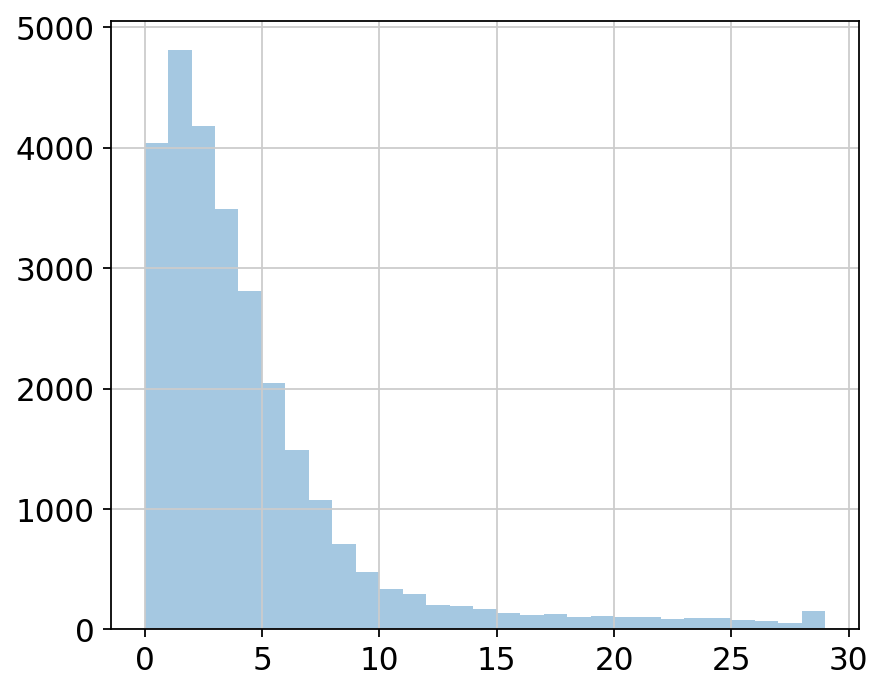

In [6]:
batch = "Sample_ID"
sc.pp.highly_variable_genes(adata, min_disp = None, max_disp = None, min_mean = None, max_mean = None, 
                            batch_key = batch, n_top_genes = 4000, flavor = "cell_ranger", subset = False)

vartab = pd.DataFrame(adata.var["highly_variable_nbatches"], index = adata.var_names)
sb.distplot(vartab, kde = False, bins = len(np.unique(adata.obs[batch])))

In [8]:
thresh = 4
hvgs = vartab[vartab.highly_variable_nbatches.values >= thresh].index
print("%s Genes kept, variable in at least %s samples" %(len(hvgs), thresh))

11324 Genes kept, variable in at least 4 samples


In [9]:
## Remove ambient genes from this list
ambis = pd.read_csv(folder + "ambients.txt", header = None)
ambis = [a for a in np.unique(ambis) if not a.startswith("muc")]

## Remove cell cycle genes from list - Mouse
cc_genes = [x.strip().capitalize() for x in open(folder + "regev_lab_cell_cycle_genes.txt")]
remove = np.unique(np.concatenate([ambis, cc_genes]))
hvgs = np.setdiff1d(hvgs, remove)

adata.var["highly_variable"] = [g in hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

11057


In [10]:
## Set it based on list to be consistent
hvgs = pd.read_csv(folder + "MonocyteExtravasation_variable_genes.txt", header = None).iloc[:, 0].values
adata.var["highly_variable"] = [g in hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

11057

### Calculate cell cycle Score and Regress out cell cycle effect, percentage mitochondrial reads

In [11]:
s_genes = cc_genes[:43]
g2m_genes = cc_genes[43:]
cc_genes = np.intersect1d(adata.var_names, cc_genes)
sc.tl.score_genes_cell_cycle(adata, s_genes = s_genes, g2m_genes = g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    557 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    558 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [12]:
sc.pp.filter_genes(adata, min_counts = 1)
sc.pp.regress_out(adata, ['percentage_mito', 'S_score', 'G2M_score'])

filtered out 433 genes that are detected in less than 1 counts
regressing out ['percent.mito', 'S_score', 'G2M_score']
    finished (0:23:57)


### Dimensionality Reduction and Visualization
As in /short_scripts/Smoked_Mice/all_2m_4m_6m/all_cell_version/filter_generate_object.ipynb

... storing 'phase' as categorical


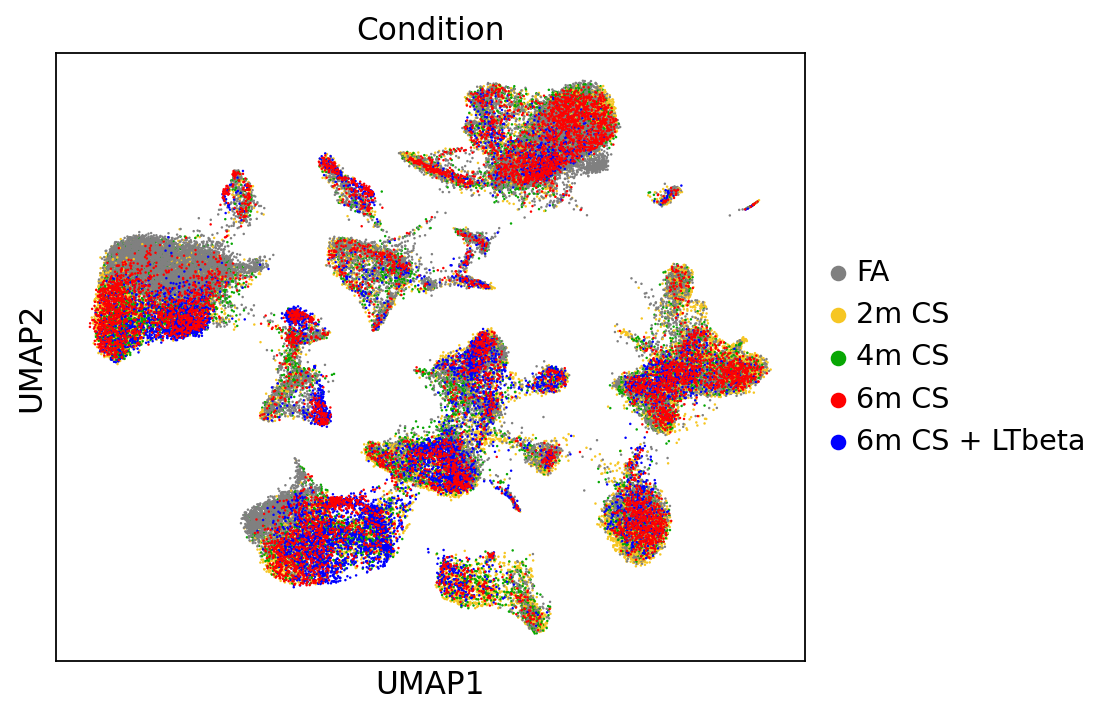

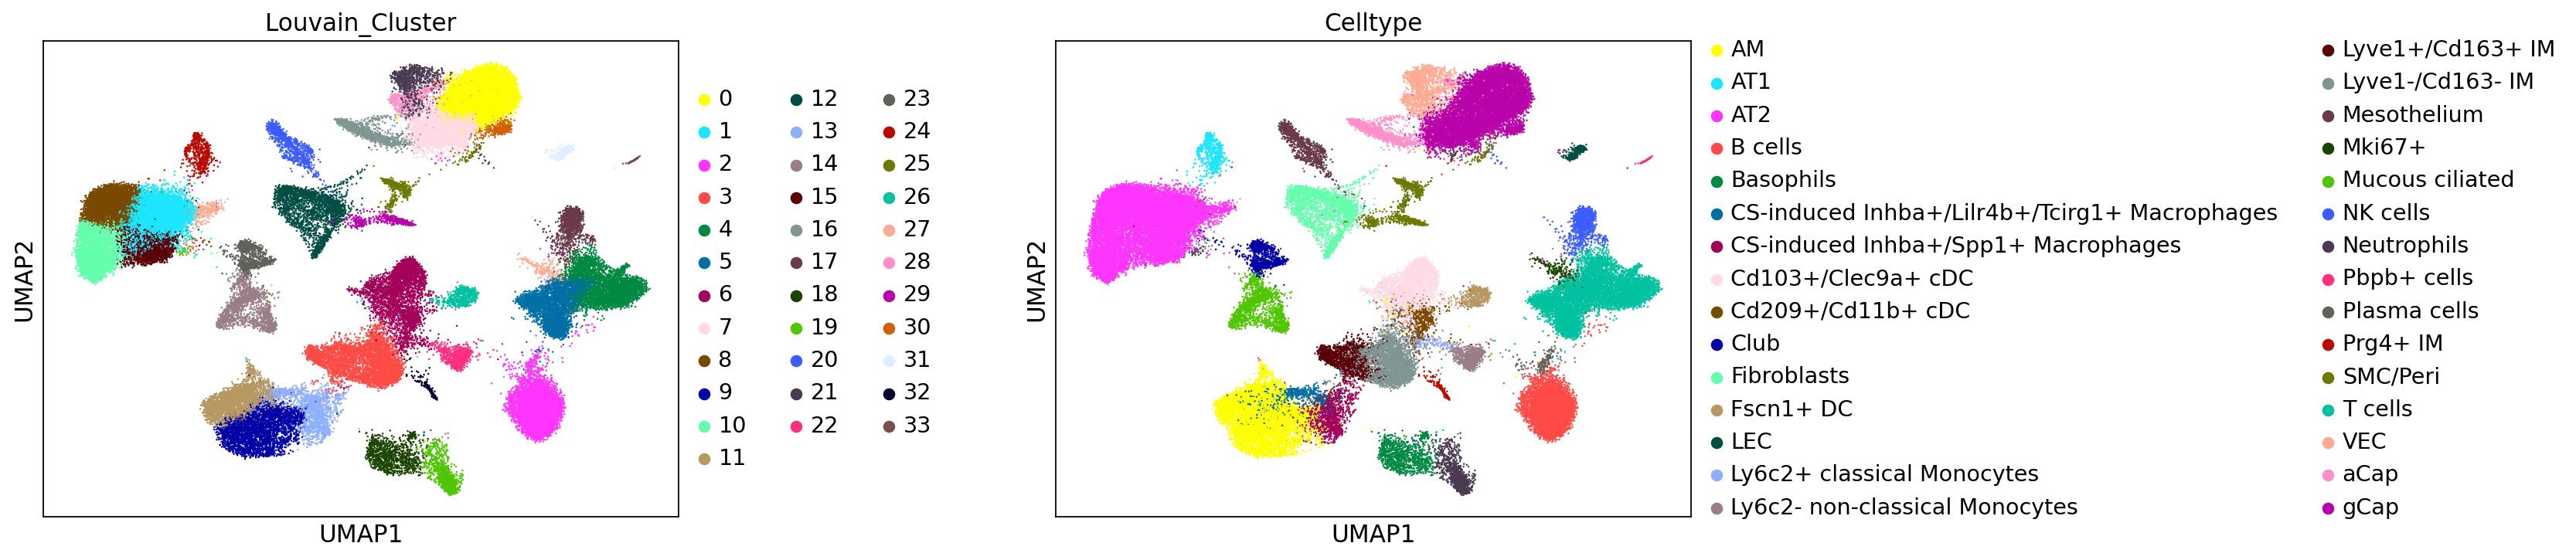

In [13]:
## Original Parameters
# sc.pp.pca(adata, n_comps = 60, use_highly_variable = True)
# sc.pp.neighbors(adata, n_pcs = 60, n_neighbors = 20)
# sc.tl.louvain(adata, resolution = 2, key_added = "Louvain_Cluster")
# sc.tl.umap(adata)

## Set it based on coordinates to be consistent with figures
adata.obsm["X_umap"] = pd.read_csv(folder + "MonocyteExtravasation_umap_coords.txt", sep = "\t", index_col = 0).values

## Set colours
adata.obs["Condition"].cat.reorder_categories(["FA", "2m CS", "4m CS", "6m CS", "6m CS + LTbeta"], inplace = True)
condition_colors = ['#808080', '#f6c623', '#08a704', '#ff0000', '#0000ff']
c = adata.obs["Louvain_Cluster"].astype("U")
adata.obs["Louvain_Cluster"] = pd.Categorical(c, categories = natsorted(np.unique(c)))

sc.pl.umap(adata, color = "Condition", palette = condition_colors, size = 5)
sc.pl.umap(adata, color = ["Louvain_Cluster", "Celltype"], size = 5, wspace = 0.45)

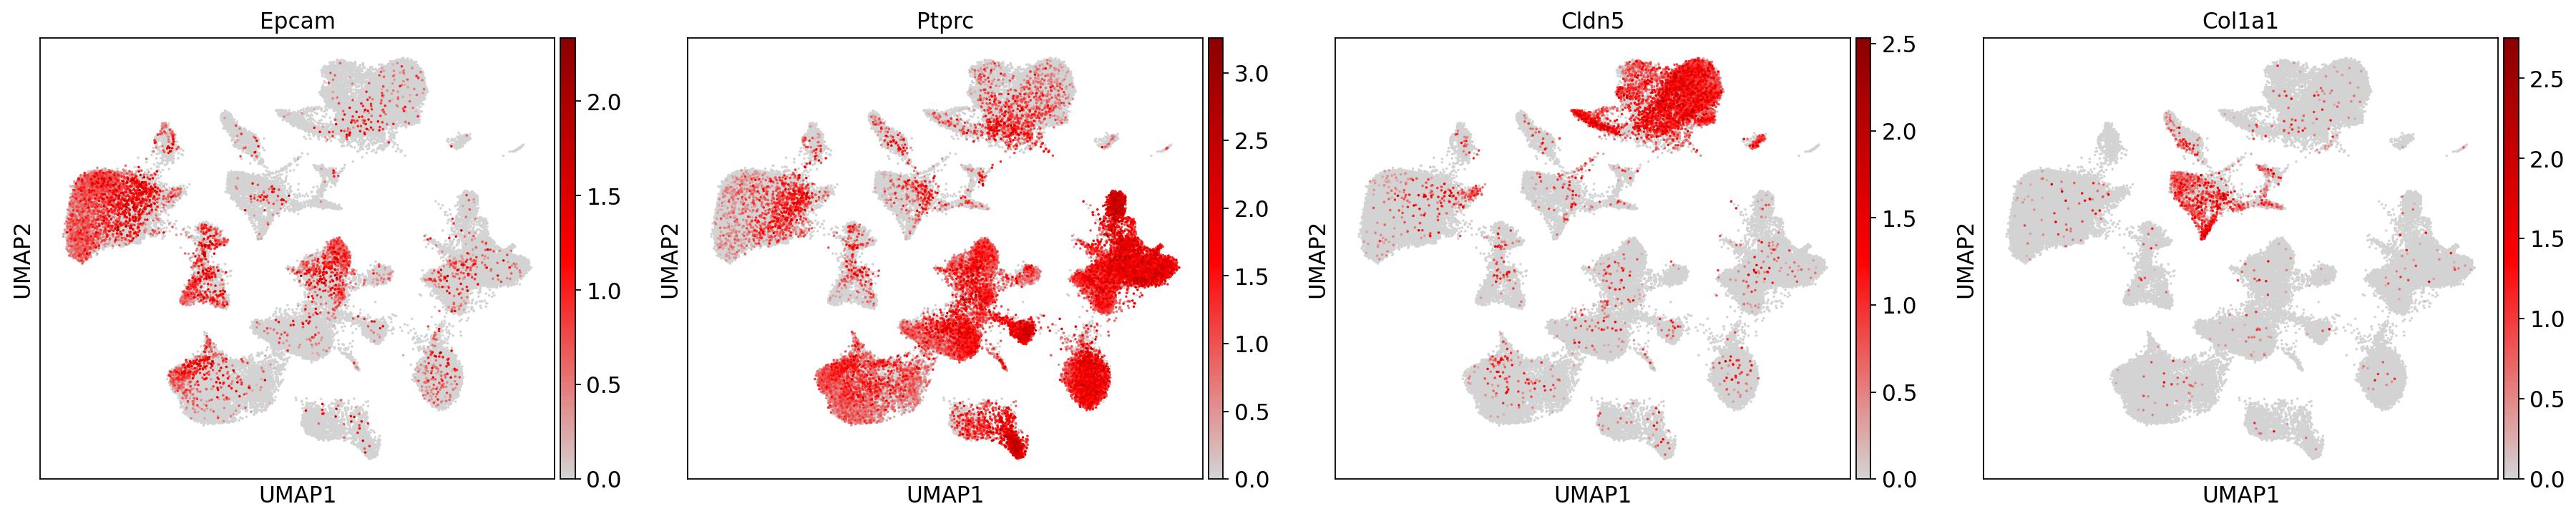

In [14]:
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)
sc.pl.umap(adata, color = ["Epcam", "Ptprc", "Cldn5", "Col1a1"], cmap = gray_red, size = 10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:58)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:03:23)
Storing dendrogram info using `.uns['dendrogram_Louvain_Cluster']`


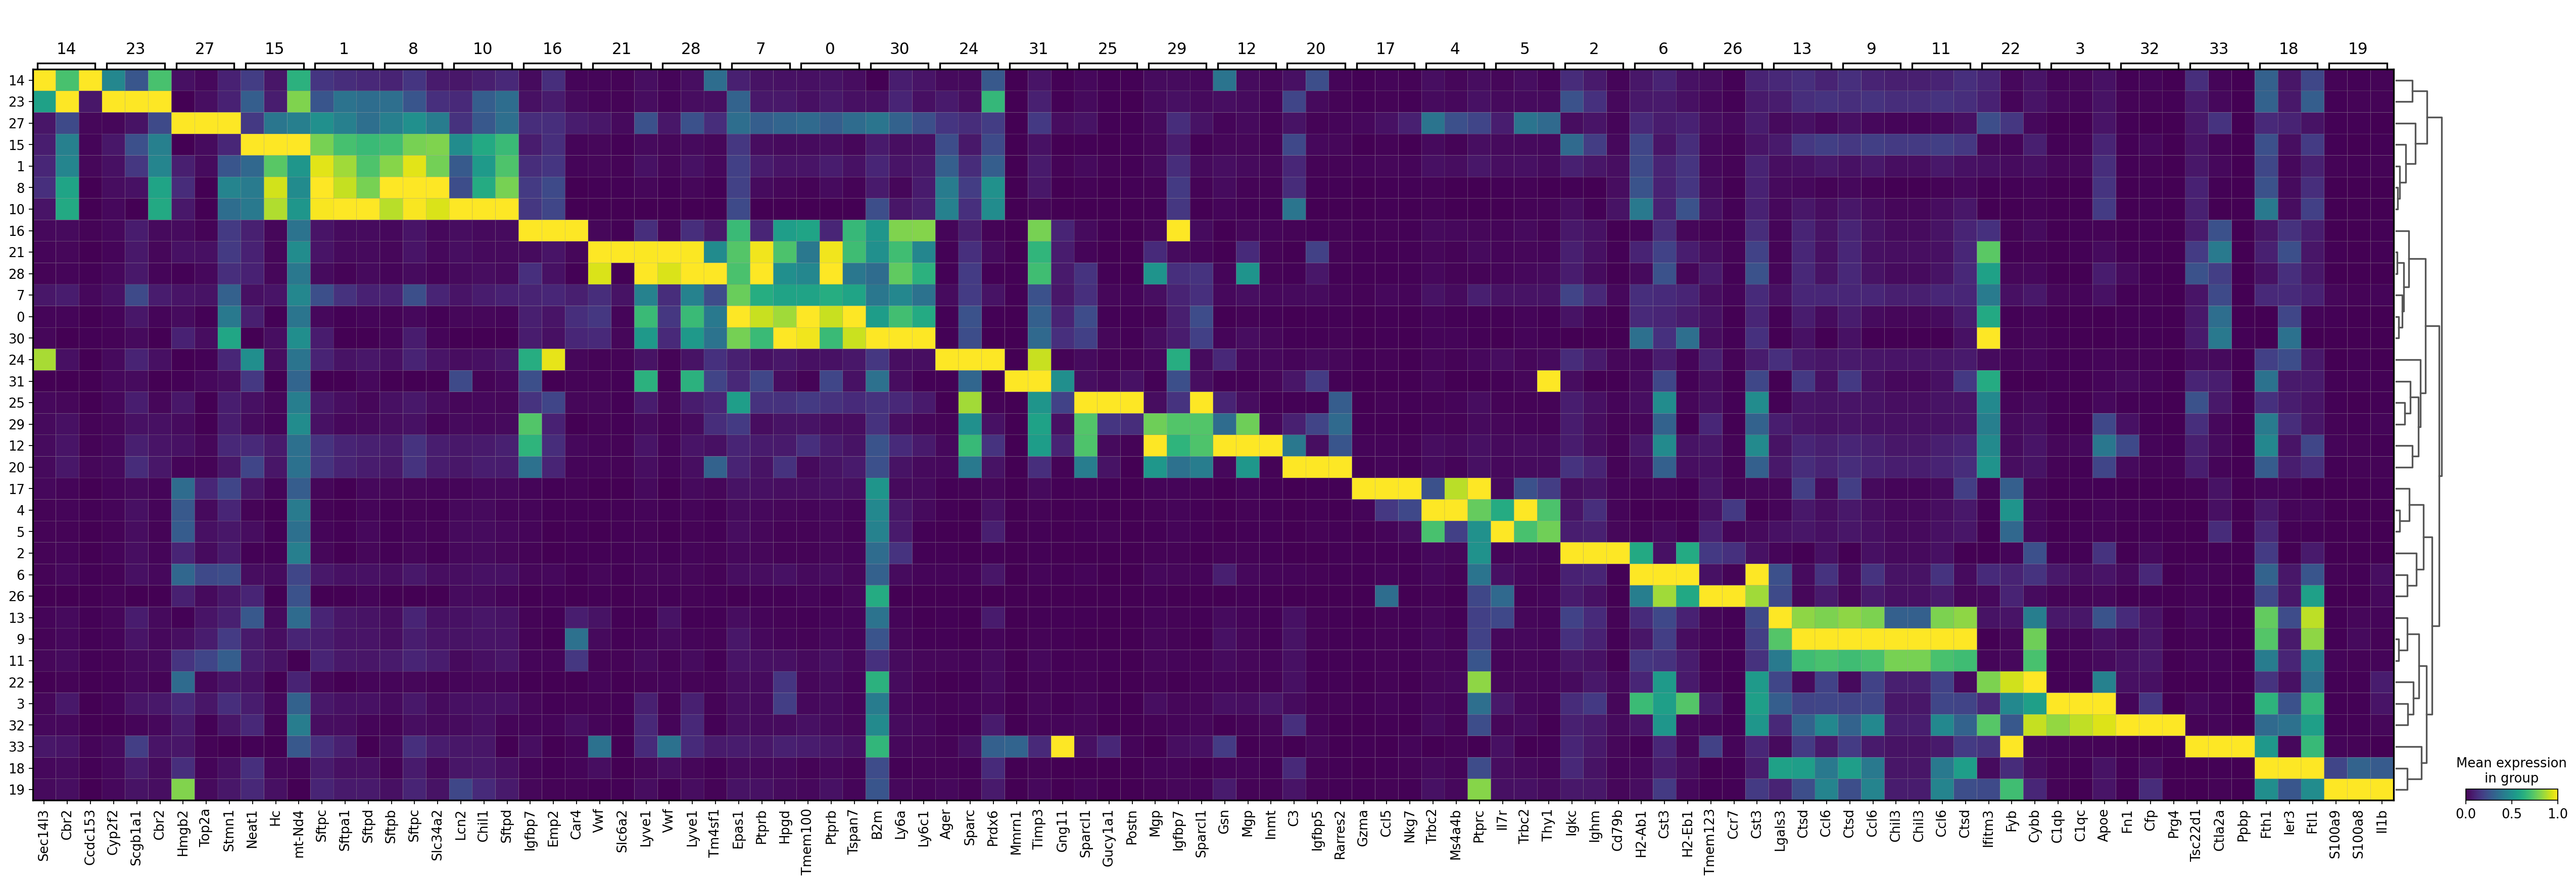

In [15]:
sc.tl.rank_genes_groups(adata, groupby = "Louvain_Cluster", method = "wilcoxon")
sc.pl.rank_genes_groups_matrixplot(adata, n_genes = 3, standard_scale = "var")